# 🧨 Stable Diffusion in JAX / Flax !

Credit: Hugging Face Team (Pedro Cuenca,Patrick von Platen)

🤗 Hugging Face [Diffusers](https://github.com/huggingface/diffusers) supports Flax since version `0.5.0`! This allows for super fast inference on Google TPUs, such as those available in Colab or through Google Cloud Platform.

This notebook shows how to run inference using JAX / Flax. If you want more details about how Stable Diffusion works or want to run it in GPU, please refer to [this Colab notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

First, make sure you are using a TPU backend. If you are running this notebook in Colab, select `Runtime` in the menu above, then select the option "Change runtime type" and then select `TPU` under the `Hardware accelerator` setting.

Note that JAX is not exclusive to TPUs, but it shines on that hardware because each TPU server has 8 TPU accelerators working in parallel.

# Setup

**Important**: If you are running this notebook in **Colab**, please uncomment and run the following cell to make sure you use the latest versions of the JAX libraries and drivers.

In [ ]:
!pip install --upgrade jax jaxlib -q
!pip install flax transformers ftfy -q
!pip install diffusers==0.5.1 -q

In [ ]:
! pip install transformers --upgrade --force-reinstall -q
! pip install httplib2 --upgrade --force-reinstall -q
! pip install typing-extensions --upgrade --force-reinstall

# Restart the notebook at this point

Re-install because we restarted the server and hence will throw "package not found"

In [1]:
!pip install --upgrade jax jaxlib -q
!pip install flax transformers ftfy -q
!pip install diffusers==0.5.1 -q

### Set up Jax Environment on Kaggle Notebok

In [2]:
#Code by Kartheek Akella  https://www.kaggle.com/asvskartheek/bert-tpus-jax-huggingface/notebook


import os
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1


    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
    print('No TPU detected. Can be changed under "Runtime/Change runtime type".')


Registered TPU: grpc://10.0.0.2:8470


In [6]:
import jax

In [6]:
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")
assert "TPU" in device_type, "Available device is not a TPU, please select TPU from Edit > Notebook settings > Hardware accelerator"

Found 8 JAX devices of type Cloud TPU.


# Then we import all the dependencies.

In [7]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline

# Model Loading

Flax weights are available in 🤗 Hub as part of the Stable Diffusion repo. The Stable Diffusion model is distributed under the CreateML OpenRail-M license. It's an open license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details, so take a moment to read them and consider carefully whether you accept the license. If you do, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

The following cell will present a login interface unless you've already authenticated before in this computer. You'll need to paste your access token.

In [5]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

TPU devices support `bfloat16`, an efficient half-float type. We'll use it for our tests, but you can also use `float32` to use full precision instead.

In [8]:
dtype = jnp.bfloat16

Flax is a functional framework, so models are stateless and parameters are stored outside them. Loading the pre-trained Flax pipeline will return both the pipeline itself and the model weights (or parameters). We are using a `bf16` version of the weights, which leads to type warnings that you can safely ignore.

In [9]:
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="bf16",
    dtype=dtype,
)

Downloading:   0%|          | 0.00/563 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some of the weights of FlaxUNet2DConditionModel were initialized in bfloat16 precision from the model checkpoint at /root/.cache/huggingface/diffusers/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/unet:
[('conv_in', 'bias'), ('conv_in', 'kernel'), ('conv_norm_out', 'bias'), ('conv_norm_out', 'scale'), ('conv_out', 'bias'), ('conv_out', 'kernel'), ('down_blocks_0', 'attentions_0', 'norm', 'bias'), ('down_blocks_0', 'attentions_0', 'norm', 'scale'), ('down_blocks_0', 'attentions_0', 'proj_in', 'bias'), ('down_blocks_0', 'attentions_0', 'proj_in', 'kernel'), ('down_blocks_0', 'attentions_0', 'proj_out', 'bias'), ('down_blocks_0', 'attentions_0', 'proj_out', 'kernel'), ('down_blocks_0', 'attentions_0', 'transformer_blocks_0', 'attn1', 'to_k', 'kernel'), ('down_blocks_0', 'attentions_0', 'transformer_blocks_0', 'attn1', 'to_out_0', 'bias'), ('down_blocks_0', 'attentions_0', 'transformer_blocks_0', 'attn1', 'to_out_0', 'kernel'), ('down_blocks_0', 

# Inferences

Since TPUs usually have 8 devices working in parallel, we'll replicate our prompt as many times as devices we have. Then we'll perform inference on the 8 devices at once, each of them being responsible for generating one image. Thus, we'll get 8 images in the same amount of time it takes for one chip to generate a single one.

After we replicate the prompt we obtain the tokenized text ids by invoking the `prepare_inputs` function of the pipeline. The length of the tokenized text is set to 77 tokens, which is the value that was used by the underlying CLIP Text model.

In [10]:
prompt = "Starfinder planet landscape. Concept art, 4k, highly detailed."
prompt = [prompt] * jax.device_count()
prompt_ids = pipeline.prepare_inputs(prompt)
prompt_ids.shape

(8, 77)

### Replication and parallelization

Model parameters and inputs have to be replicated across the 8 parallel devices we have. The parameters dictionary is replicated using `flax.jax_utils.replicate`, which traverses the dictionary and changes the shape of the weights so they are repeated 8 times. Arrays are replicated using `shard`.

In [11]:
p_params = replicate(params)

In [12]:
prompt_ids = shard(prompt_ids)
prompt_ids.shape

(8, 1, 77)

That shape means that each one of the `8` devices will receive as an input a `jnp` array with shape `(1, 77)`. `1` is therefore the batch size per device. In TPUs with sufficient memory, it could be larger than `1` if we wanted to generate multiple images (per chip) at once.

We are almost ready to generate images! We just need to create a random number generator to pass to the generation function. This is the standard procedure in Flax, which is very serious and opinionated about random numbers – all functions that deal with random numbers are expected to receive a generator. This ensures reproducibility, even when we are training across multiple distributed devices.

The helper function below uses a seed to initialize a random number generator. As long as we use the same seed, we'll get the exact same results. Feel free to use different seeds when exploring results later in the notebook.

In [13]:
def create_key(seed=0):
    return jax.random.PRNGKey(seed)

We obtain a rng and then "split" it 8 times so each device receives a different generator. Therefore, each device will create a different image, and the full process is reproducible.

In [14]:
rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

JAX code can be compiled to an efficient representation that runs very fast. However, we need to ensure that all inputs have the same shape in subsequent calls; otherwise, JAX will have to compile the code again and we wouldn't be able to take advantage of the optimized speed.

The Flax pipeline can compile the code for us if we pass `jit = True` as an argument. It will also ensure that the model runs in parallel in the 8 available devices.

The first time we run the following cell it will take a long time to compile, but subequent calls (even with different inputs) will be much faster. For example, it took more than a minute to compile in a TPU v2-8 when I tested, but then it takes about **`7s`** for future inference runs.

In [15]:
%%time

images = pipeline(prompt_ids, p_params, rng, jit=True)[0]

CPU times: user 1min 45s, sys: 1min 17s, total: 3min 3s
Wall time: 2min 17s


In [16]:
%%time

images = pipeline(prompt_ids, p_params, rng, jit=True)[0]

CPU times: user 3.14 s, sys: 3.59 s, total: 6.73 s
Wall time: 5.32 s


We need to slighly reshape the images to make `PIL.Image` happy.

images = images.reshape((num_devices, ) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)

In [17]:
images = images.reshape((num_devices, ) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)
images

[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F304D03F150>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304BE090D0>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304C0B57D0>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304C0B5C10>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304C0B5050>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304BD8BF10>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304BE15990>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7F304E870A50>]

### Visualization

Let's create a couple of helper functions to:
- Convert the image tensor to PIL images.
- Visualize them in a grid.

In [18]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

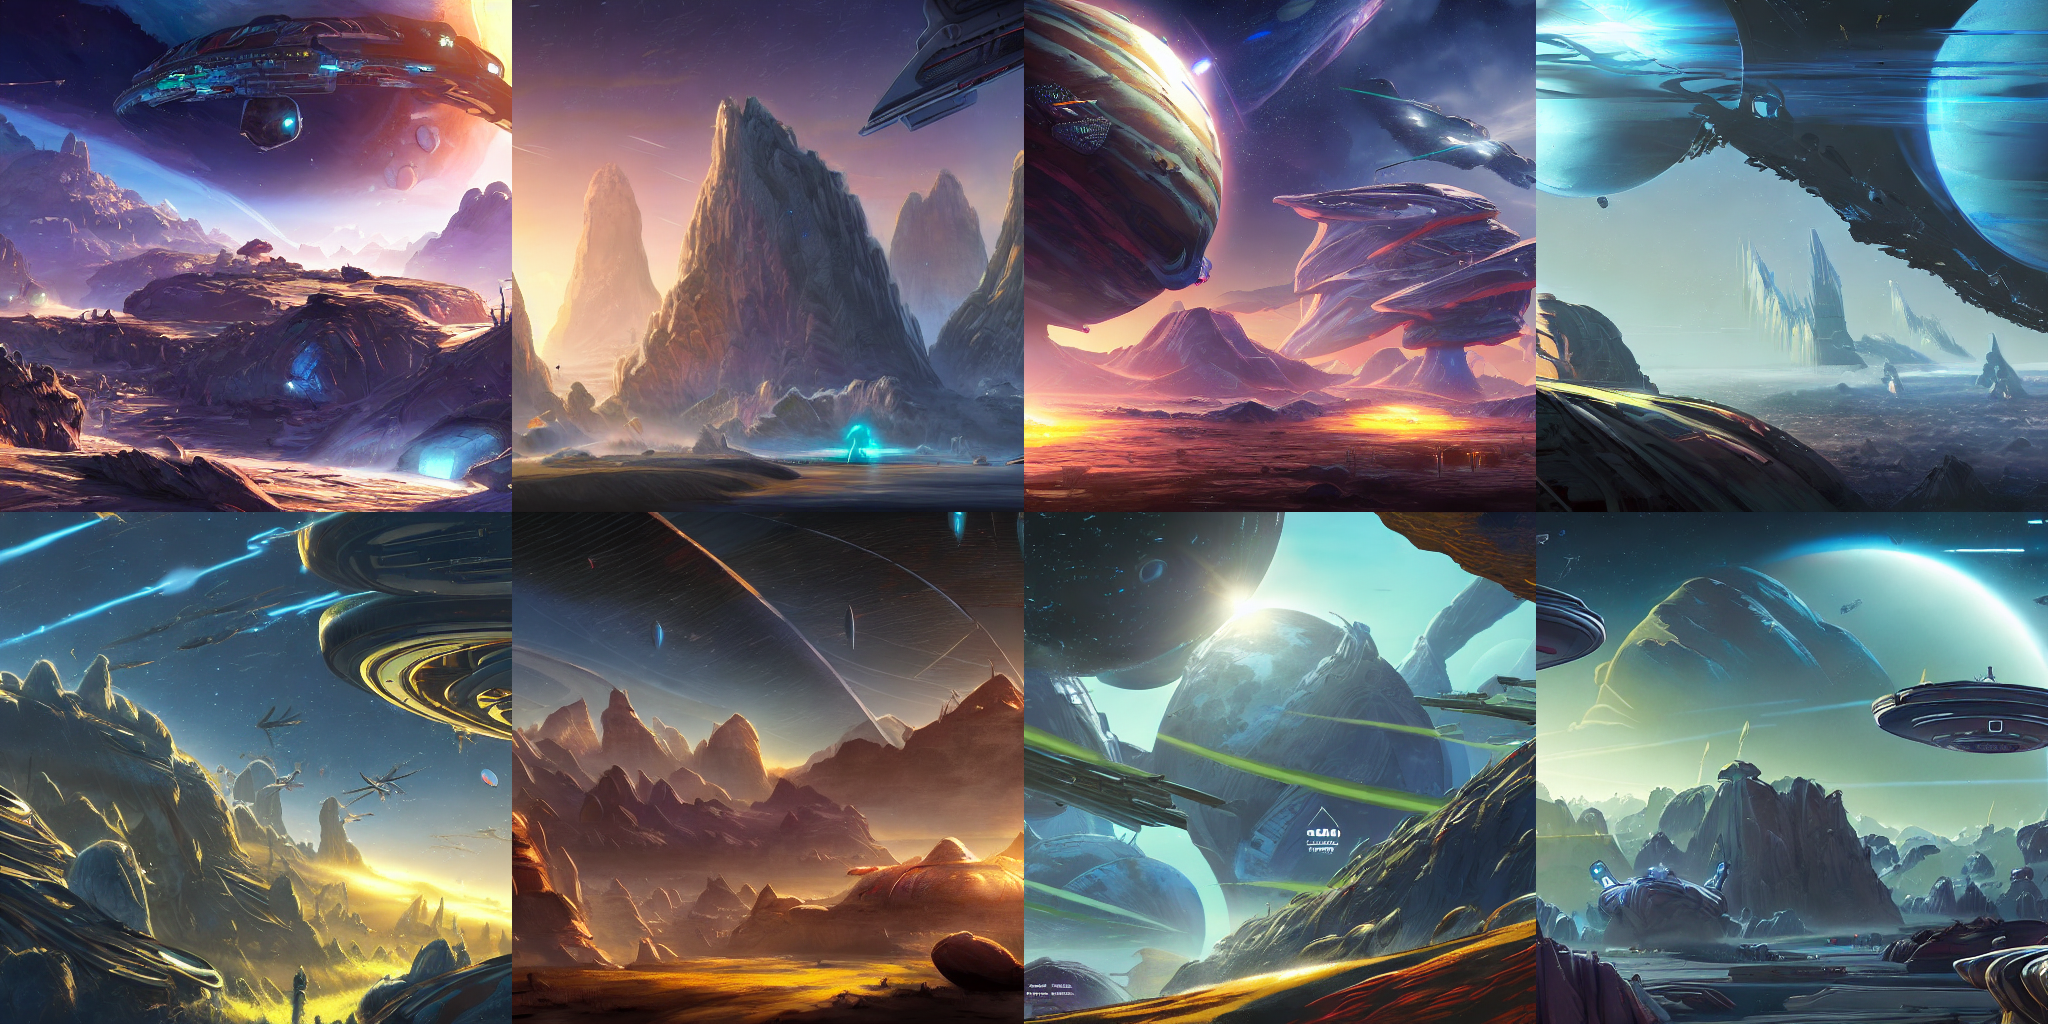

In [19]:
image_grid(images, 2, 4)

## Using different prompts

We don't have to replicate the _same_ prompt in all the devices. We can do whatever we want: generate 2 prompts 4 times each, or even generate 8 different prompts at once. Let's do that!

First, we'll refactor the input preparation code into a handy function:

In [21]:
prompts = [
    "a couple holding hands with plants growing out of their heads, growth of a couple, rainy day, atmospheric, bokeh matte masterpiece by artgerm by wlop by alphonse muhca ",
    "detailed portrait beautiful Neon Operator Girl, cyberpunk futuristic neon, reflective puffy coat, decorated with traditional Japanese ornaments by Ismail inceoglu dragan bibin hans thoma greg rutkowski Alexandros Pyromallis Nekro Rene Maritte Illustrated, Perfect face, fine details, realistic shaded, fine-face, pretty face",
    "symmetry!! portrait of minotaur, sci - fi, glowing lights!! intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha, 8 k ",
    "Human, Simon Stalenhag in forest clearing style, trends on artstation, artstation HD, artstation, unreal engine, 4k, 8k",
    "portrait of a young ruggedly handsome but joyful pirate, male, masculine, upper body, red hair, long hair, d & d, fantasy, roguish smirk, intricate, elegant, highly detailed, digital painting, artstation, concept art, matte, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha ",
    "Symmetry!! portrait of a sith lord, warrior in sci-fi armour, tech wear, muscular!! sci-fi, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus, illustration, art by artgerm and greg rutkowski and alphonse mucha",
    "highly detailed portrait of a cat knight wearing heavy armor, stephen bliss, unreal engine, greg rutkowski, loish, rhads, beeple, makoto shinkai and lois van baarle, ilya kuvshinov, rossdraws, tom bagshaw, tom whalen, alphonse mucha, global illumination, god rays, detailed and intricate environment ",
    "black and white portrait photo, the most beautiful girl in the world, earth, year 2447, cdx"
]

CPU times: user 3.06 s, sys: 3.45 s, total: 6.51 s
Wall time: 5.14 s


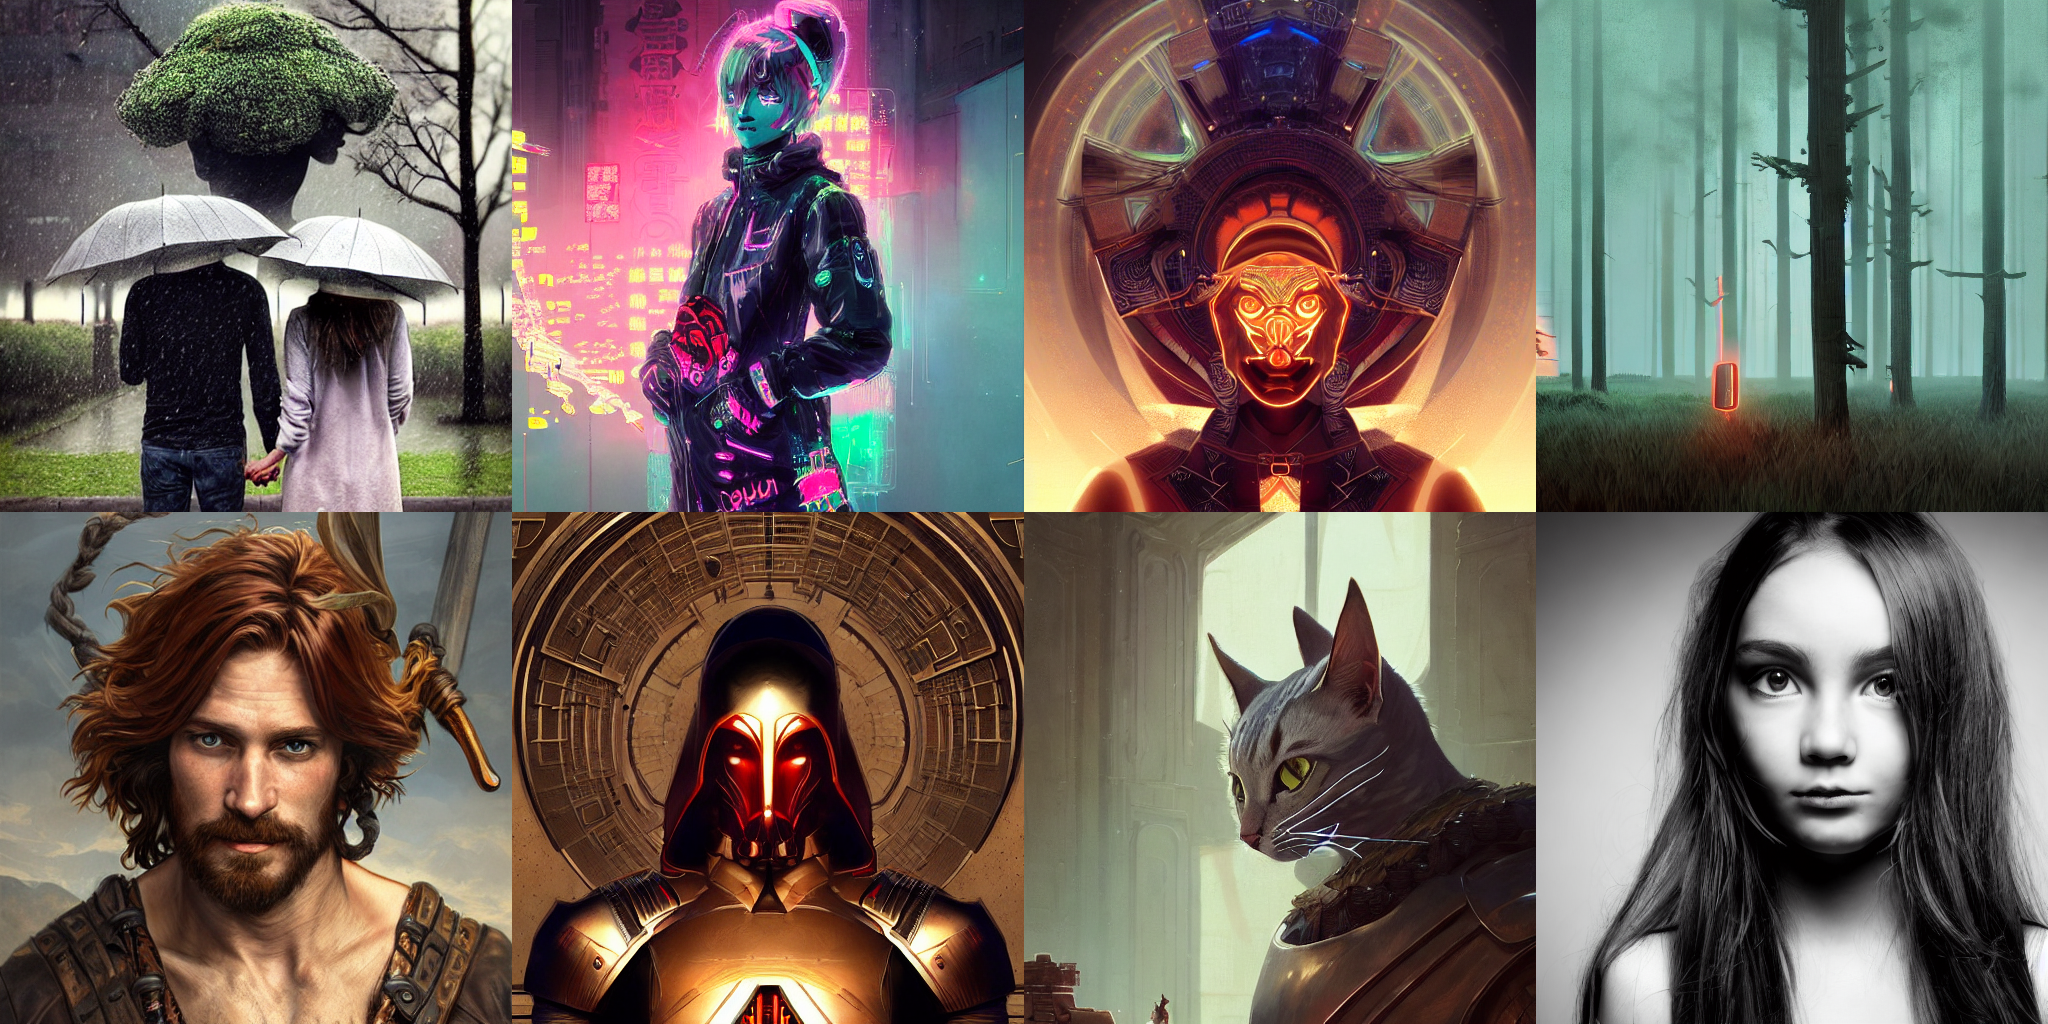

In [22]:
%%time
prompt_ids = pipeline.prepare_inputs(prompts)
prompt_ids = shard(prompt_ids)

images = pipeline(prompt_ids, p_params, rng, jit=True).images
images = images.reshape((num_devices, ) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)

image_grid(images, 2, 4)

## How does parallelization work?****

We said before that the `diffusers` Flax pipeline automatically compiles the model and runs it in parallel on all available devices. We'll now briefly look inside that process to show how it works.

JAX parallelization can be done in multiple ways. The easiest one revolves around using the `jax.pmap` function to achieve single-program, multiple-data (SPMD) parallelization. It means that we'll run several copies of the same code, each one on different data inputs. More sophisticated approaches are possible, we invite you to go over the [JAX documentation](https://jax.readthedocs.io/en/latest/index.html) and the [`pjit` pages](https://jax.readthedocs.io/en/latest/jax-101/08-pjit.html?highlight=pjit) to explore this topic if you are interested!

`jax.pmap` does two things for us:
- Compiles (or `jit`s) the code, as if we had invoked `jax.jit()`. This does not happen when we call `pmap`, but the first time the pmapped function is invoked.
- Ensures the compiled code runs in parallel in all the available devices.

To show how it works we `pmap` the `_generate` method of the pipeline, which is the private method that runs generates images. Please, note that this method may be renamed or removed in future releases of `diffusers`.

In [24]:
p_generate = pmap(pipeline._generate)

After we use `pmap`, the prepared function `p_generate` will conceptually do the following:
* Invoke a copy of the underlying function `pipeline._generate` in each device.
* Send each device a different portion of the input arguments. That's what sharding is used for. In our case, `prompt_ids` has shape `(8, 1, 77, 768)`. This array will be split in `8` and each copy of `_generate` will receive an input with shape `(1, 77, 768)`.

We can code `_generate` completely ignoring the fact that it will be invoked in parallel. We just care about our batch size (`1` in this example) and the dimensions that make sense for our code, and don't have to change anything to make it work in parallel.

The same way as when we used the pipeline call, the first time we run the following cell it will take a while, but then it will be much faster.

In [25]:
%%time

images = p_generate(prompt_ids, p_params, rng)
images = images.block_until_ready()
images.shape

CPU times: user 1min 25s, sys: 1min 5s, total: 2min 30s
Wall time: 1min 54s


(8, 1, 512, 512, 3)

In [27]:
images.shape

(8, 1, 512, 512, 3)

We use `block_until_ready()` to correctly measure inference time, because JAX uses asynchronous dispatch and returns control to the Python loop as soon as it can. You don't need to use that in your code; blocking will occur automatically when you want to use the result of a computation that has not yet been materialized.